# The "Magic" of Santander
https://www.kaggle.com/mayi140611/200-magical-models-santander-0-920/edit
In this kernel, we will display pictures of the Santander magic! Previously [here][1], in "Modified Naive Bayes", we saw that we can model each variable separately and then combine the 200 models to score LB 0.899. 

We will do the same here after adding a "magic" feature to each variable. We will then ensemble the 200 models with logistic regression and score LB 0.920  
  
![image](http://playagricola.com/Kaggle/magic41019.jpg)
  
[1]: https://www.kaggle.com/cdeotte/modified-naive-bayes-santander-0-899

# The "Magic" Feature
When LGBM "looks" at the histogram for `Var_198`, it "sees" that when `var_198<13` the probability of having `target=1` is high. And when `var_198>13` the probability is low. 

This can be displayed by showing the predictions made by LGBM (when building a model from only the variable `var_198`). LGBM basically predicts `target=0.18` for `var_198<13` and `target=0.10` otherwise. 
  
![image](http://playagricola.com/Kaggle/198without.png) 

# The "Magic" Feature
When LGBM "looks" at the histogram for `Var_198`, it "sees" that when `var_198<13` the probability of having `target=1` is high. And when `var_198>13` the probability is low. 

This can be displayed by showing the predictions made by LGBM (when building a model from only the variable `var_198`). LGBM basically predicts `target=0.18` for `var_198<13` and `target=0.10` otherwise. 
  
![image](http://playagricola.com/Kaggle/198without.png)  
  
LGBM "divides" the histogram with **vertical lines** because LGBM does not see **horizontal** differences. A histogram places multiple values into a single bin and produces a smooth picture. 

If you place every value in its own bin, you will have a jagged picture, where bars change heights from value to value. Some values are unique, some values occur dozens of times (and in the case of `var_108`, some values occur over 300 times!!) Below is a histogram with one value per bin and we zoom in on `11.0000<x<11.1000`. We see that value `11.0712` occurs 5 times and its close neighbor `11.0720` occurs only once.  
    
![image](http://playagricola.com/Kaggle/198zoom3.png)   
  
These counts are the "magic" feature. For each variable, we make a new feature (column) whose value is the number of counts of the corresponding variable. An example of this new column is displayed above next to the histogram. When LGBM has this new feature, it can now "divide" the histogram with **horizontal lines** in addition to vertical.  
  
![image](http://playagricola.com/Kaggle/198with.png)  
  
Notice now that LGBM predicts `target=0.1` when `var_198<13` AND `count=1`. When  `var_198<13` AND `count>1`, it predicts `target=0.36`. This improvement (using the magic) causes validation AUC to become 0.551 as opposed to 0.547 when using `var_198` alone.

# Why is the Magic difficult to find?
The "magic" is difficult to find because the new feature `Var_198_FE` interacts with `Var_198`. Therefore if you add the new feature to an LGBM with `feature_fraction=0.05`, you will not increase your CV or LB. You must set `feature_fraction=1.0`. Then you will gain the benefit from the new feature but you also have the determental effect of modeling spurious original variable interactions. None-the-less, adding the new feature and using `feature_fraction=1.0` achieves CV 0.910. To reach 0.920, we must remove the spurious effects from the original variable interactions.  
  
UPDATE: I just discovered another reason why magic is hidden. When calculating frequency counts for the test data, you must remove the **fake** test data before counting. (Fake test described [here][1]) If you don't, then your test predictions will score LB 0.900 instead of LB 0.910 and you may disregard frequency counts as useless.

# Maximizing Magic Feature
To maximize the gain of the "magic" feature (and climb from LB 0.910 to 0.920), we must allow the new feature to interact with the original variables while preventing the original variables from interacting with each other. Here are 3 ways to do that:
* Use Data Augmentation (as shown in Jiwei's awesome kernel [here][2]). You must keep original and new feature in same row.
* Use 200 separate models as shown in this kernel below.
* Merge new feature and original feature into one feature. In original data, simply add 200 to each unique value. (And don't add new columns)

# Let's Begin
When counting the occurence of each value, we will merge the training data and **real** test data first, and count everything together. In YaG320's brilliant kernel [here][1], we learned that half the test data is fake.  
  
[1]: https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split
[2]: https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment

In [1]:
# LOAD LIBRARIES
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd, numpy as np, gc
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import statsmodels.api as sm

# GET INDICIES OF REAL TEST DATA FOR FE
#######################
# TAKE FROM YAG320'S KERNEL
# https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split

test_path = '../input/test.csv'

df_test = pd.read_csv(test_path)
df_test.drop(['ID_code'], axis=1, inplace=True)
df_test = df_test.values

unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in range(df_test.shape[1]):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print('Found',len(real_samples_indexes),'real test')
print('Found',len(synthetic_samples_indexes),'fake test')

###################

d = {}
for i in range(200): d['var_'+str(i)] = 'float32'
d['target'] = 'uint8'
d['ID_code'] = 'object'

train = pd.read_csv('../input/train.csv', dtype=d)
test = pd.read_csv('../input/test.csv', dtype=d)

print('Loaded',len(train),'rows of train')
print('Loaded',len(test),'rows of test')

Found 100000 real test
Found 100000 fake test
Loaded 200000 rows of train
Loaded 200000 rows of test


In [2]:
# FREQUENCY ENCODE
def encode_FE(df,col,test):
    cv = df[col].value_counts()
    nm = col+'_FE'
    df[nm] = df[col].map(cv)
    test[nm] = test[col].map(cv)
    test[nm].fillna(0,inplace=True)
    if cv.max()<=255:
        df[nm] = df[nm].astype('uint8')
        test[nm] = test[nm].astype('uint8')
    else:
        df[nm] = df[nm].astype('uint16')
        test[nm] = test[nm].astype('uint16')        
    return

test['target'] = -1
comb = pd.concat([train,test.loc[real_samples_indexes]],axis=0,sort=True)
for i in range(200): encode_FE(comb,'var_'+str(i),test)
train = comb[:len(train)]; del comb
print('Added 200 new magic features!')

Added 200 new magic features!


VAR_0 with magic val_auc = 0.54785


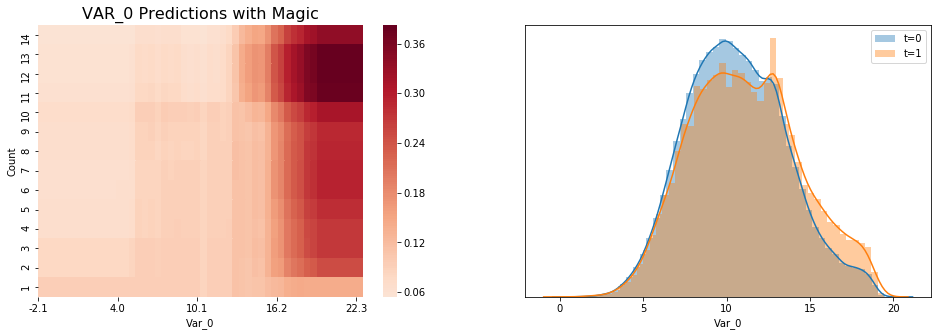

VAR_0 without magic val_auc = 0.53248


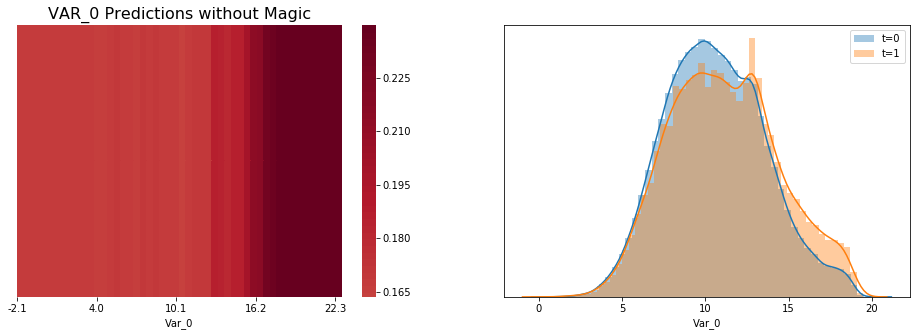

VAR_1 with magic val_auc = 0.54527


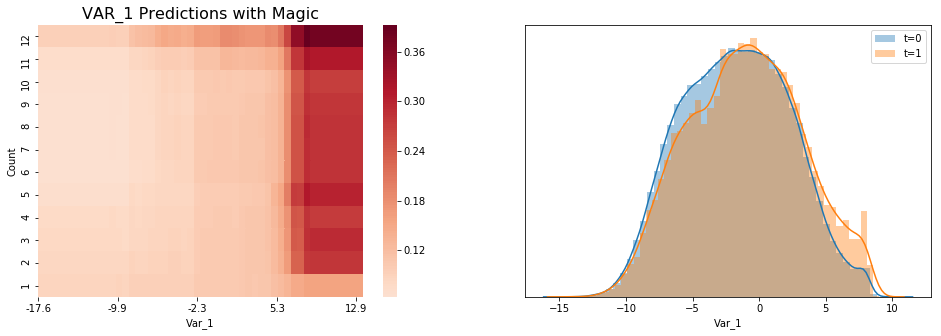

VAR_1 without magic val_auc = 0.54372


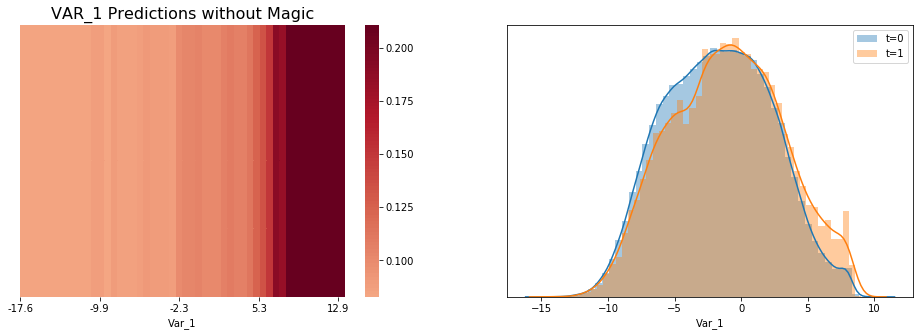

VAR_2 with magic val_auc = 0.55076


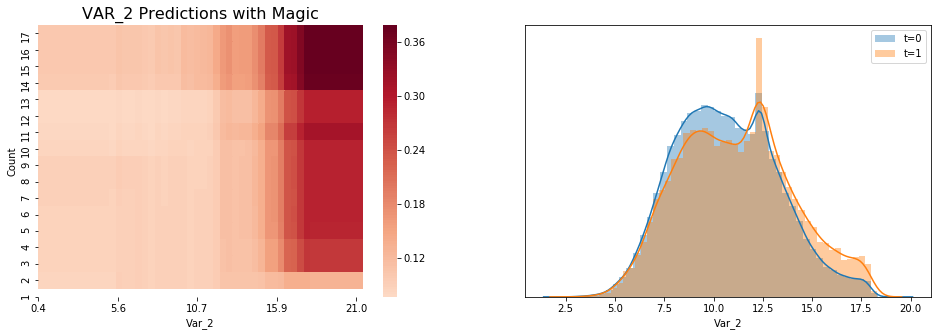

VAR_2 without magic val_auc = 0.55065


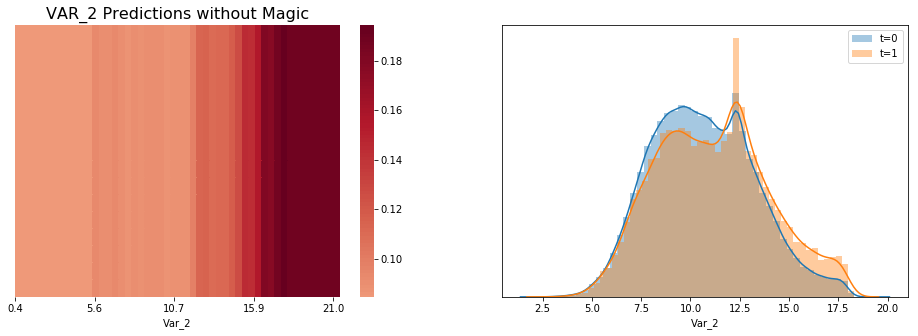

VAR_3 with magic val_auc = 0.50724


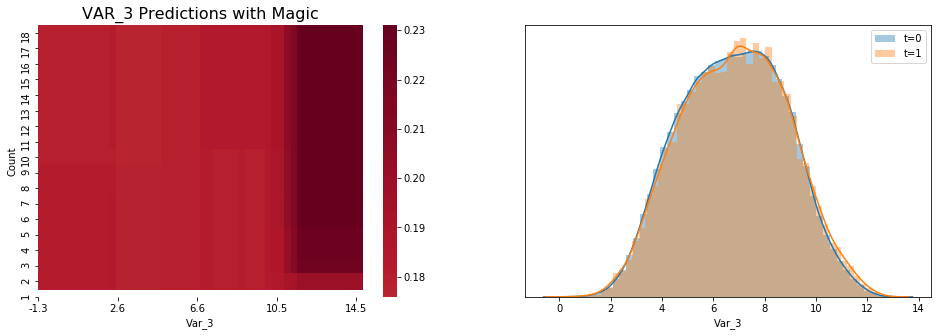

VAR_3 without magic val_auc = 0.50568


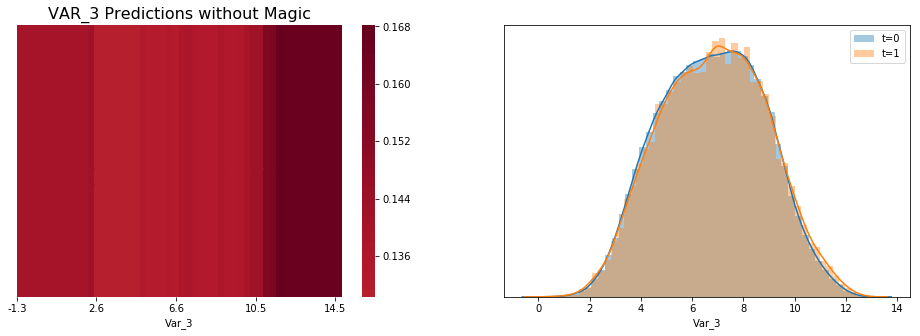

VAR_4 with magic val_auc = 0.50604


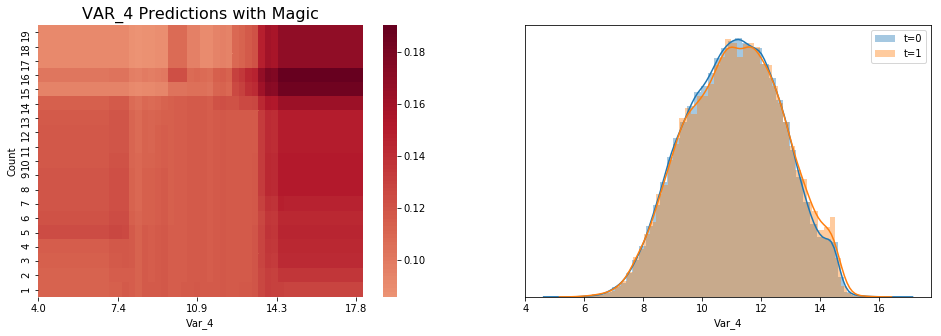

VAR_4 without magic val_auc = 0.50517


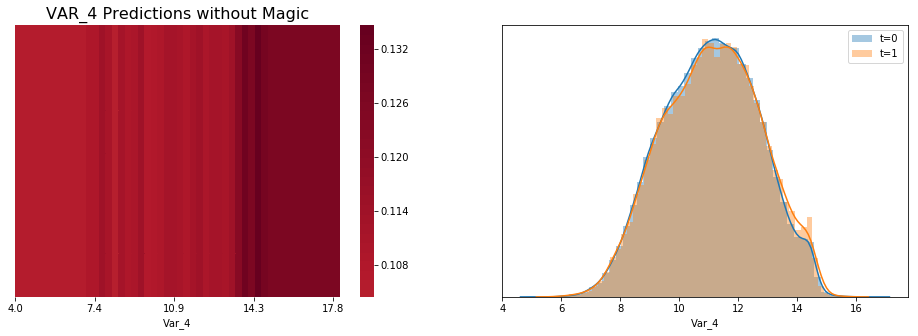

VAR_5 with magic val_auc = 0.5208


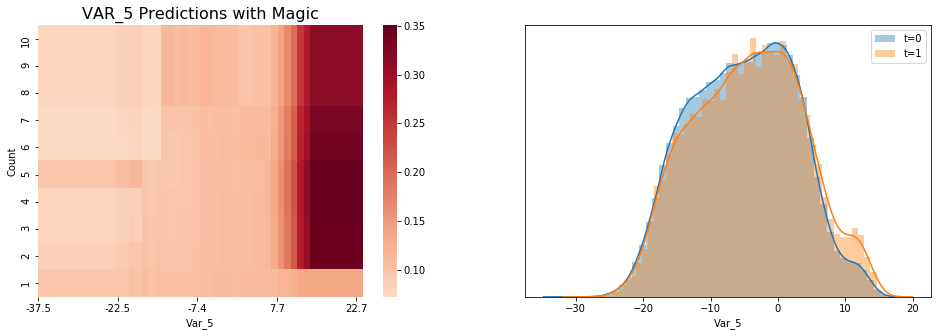

VAR_5 without magic val_auc = 0.51441


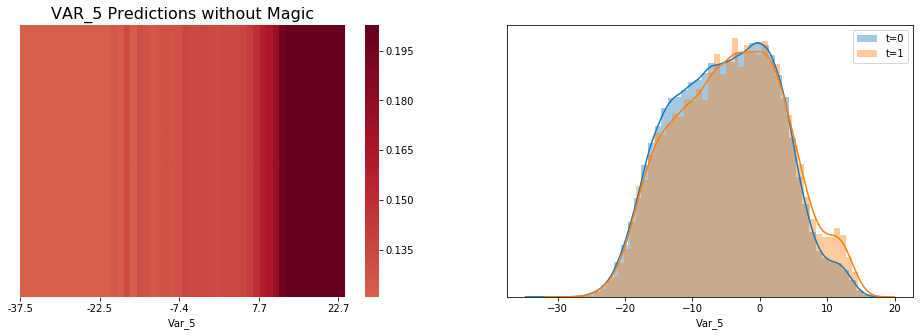

VAR_6 with magic val_auc = 0.5388


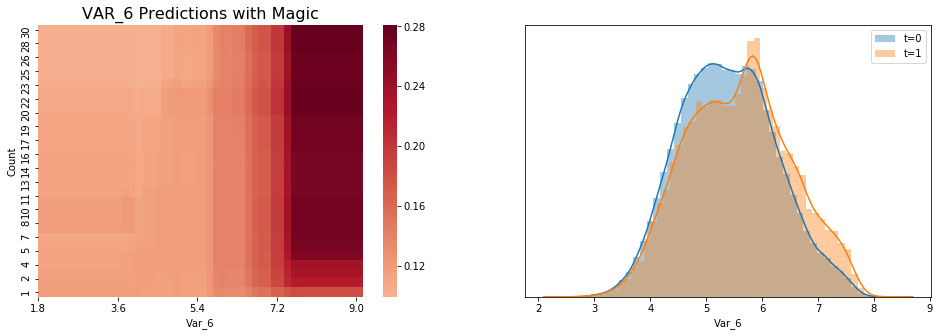

VAR_6 without magic val_auc = 0.53545


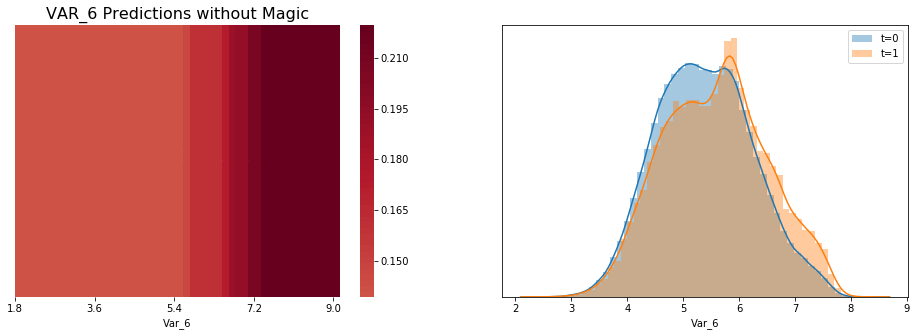

VAR_7 with magic val_auc = 0.50199


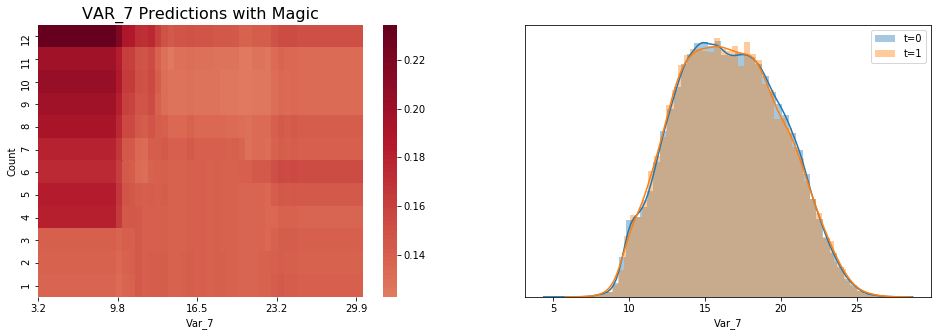

VAR_7 without magic val_auc = 0.50325


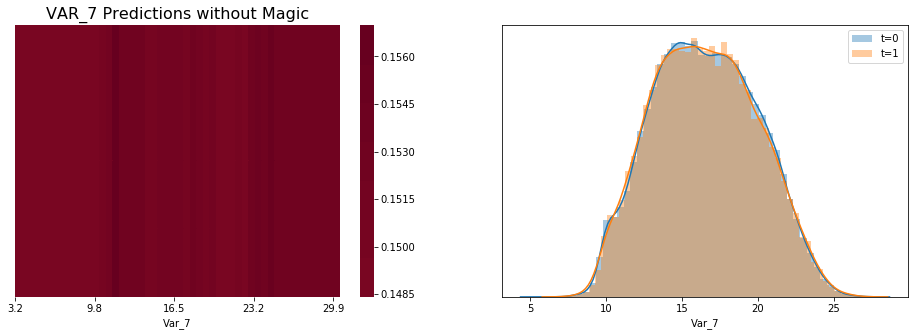

VAR_8 with magic val_auc = 0.51613


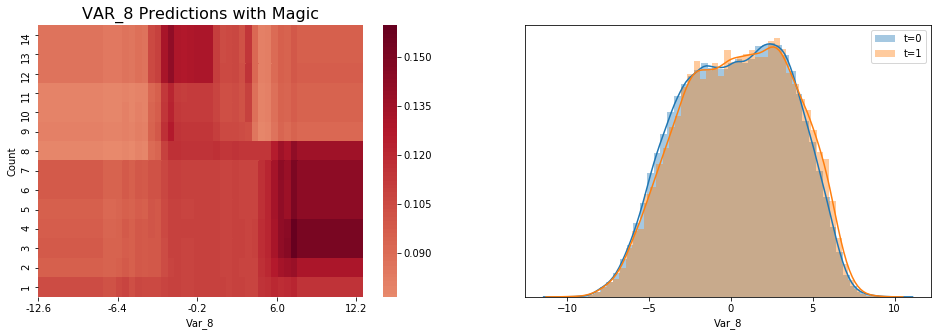

VAR_8 without magic val_auc = 0.50237


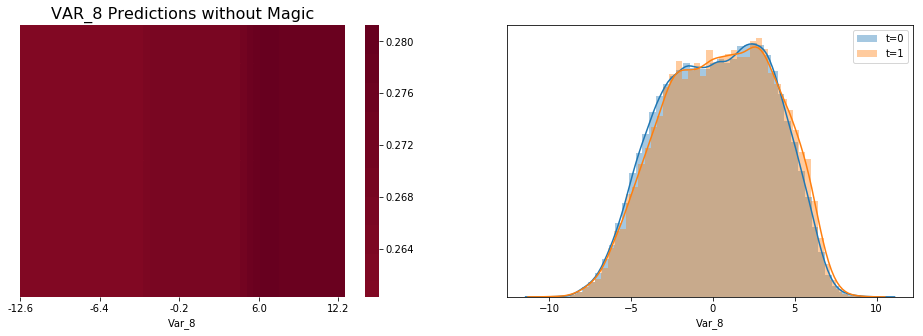

VAR_9 with magic val_auc = 0.53583


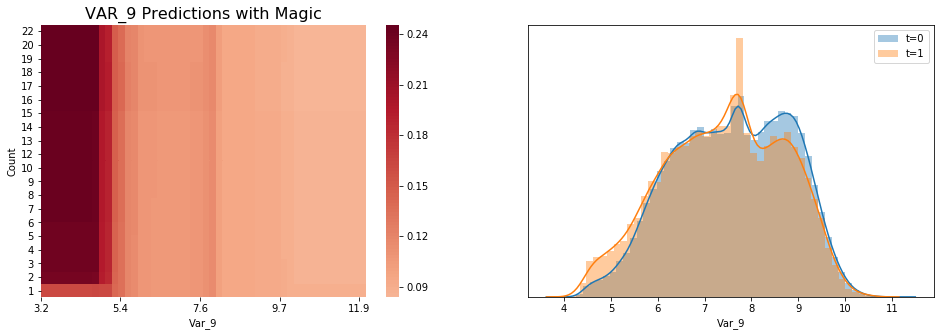

VAR_9 without magic val_auc = 0.54106


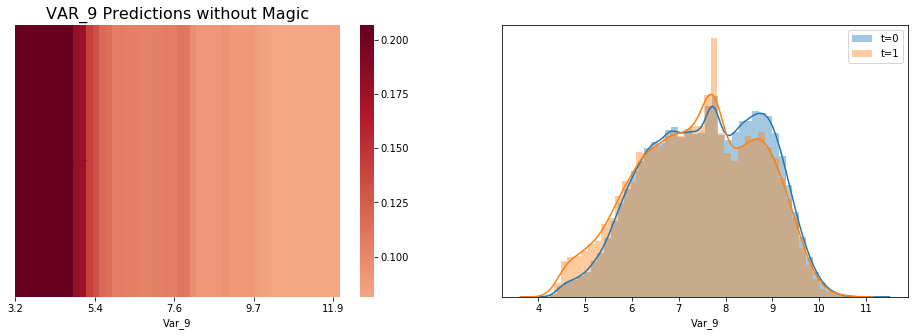

VAR_10 with magic val_auc = 0.50207


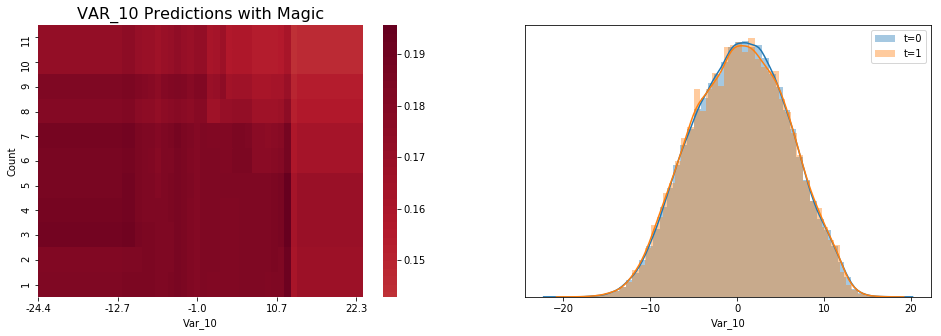

VAR_10 without magic val_auc = 0.50174


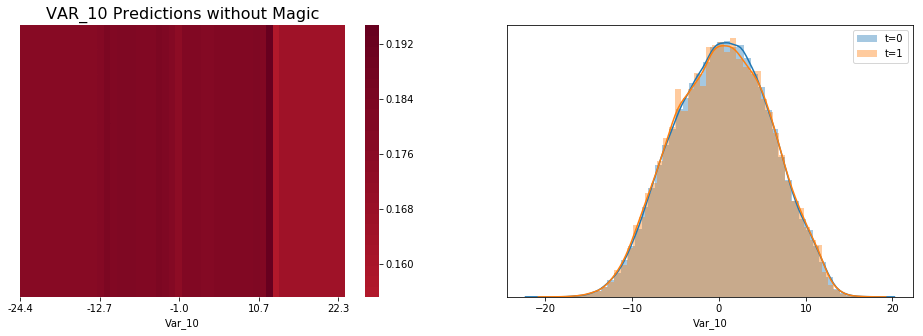

VAR_11 with magic val_auc = 0.51486


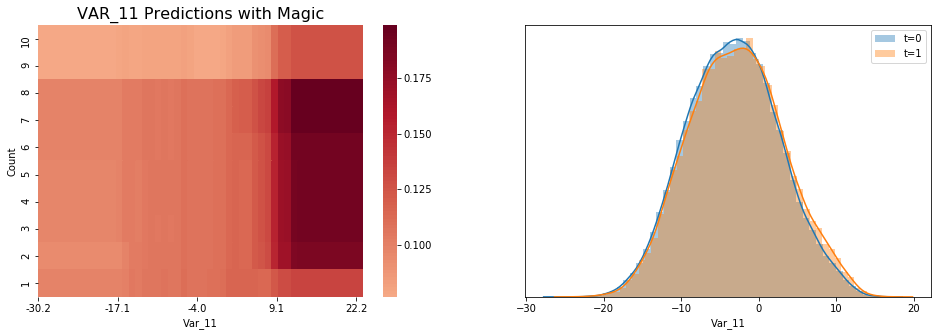

VAR_11 without magic val_auc = 0.51038


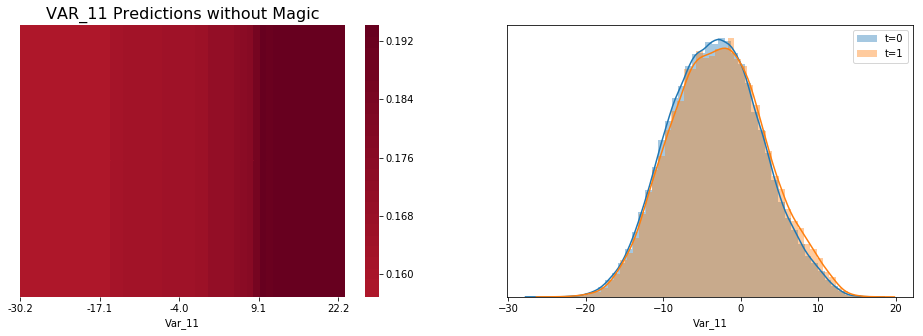

VAR_12 with magic val_auc = 0.55044


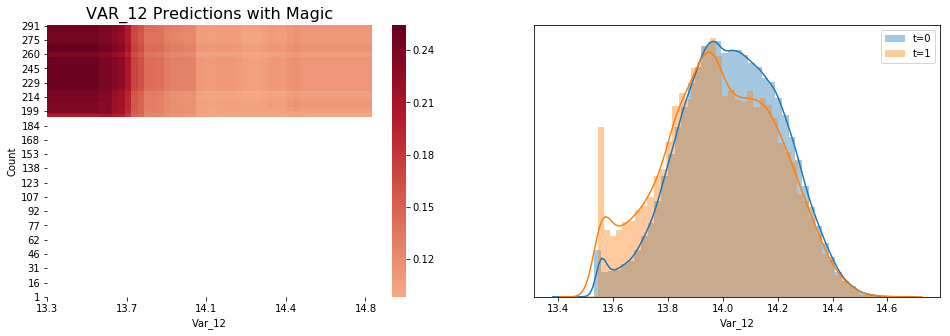

VAR_12 without magic val_auc = 0.55121


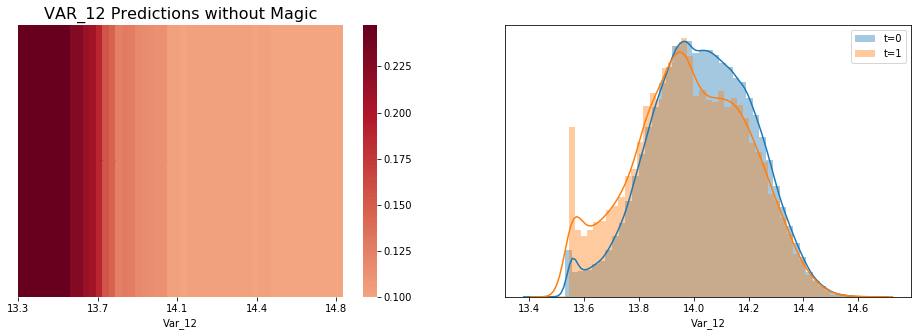

VAR_13 with magic val_auc = 0.5522


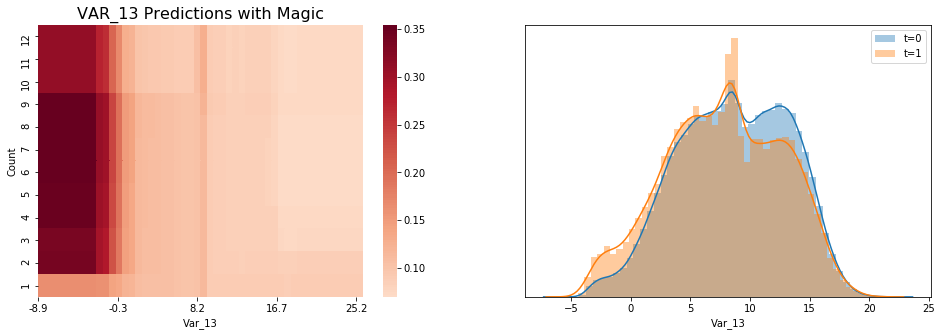

VAR_13 without magic val_auc = 0.54974


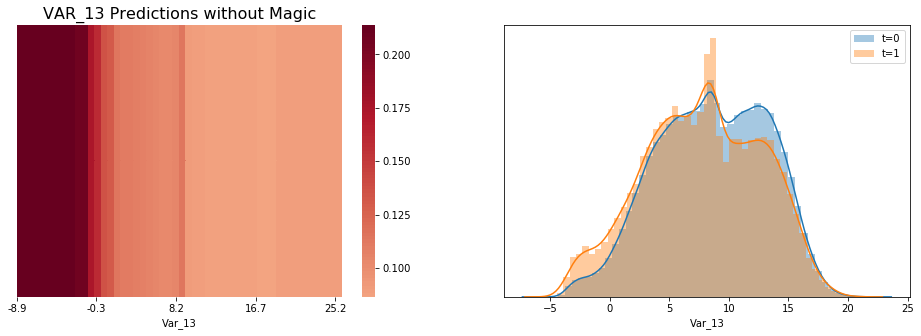

VAR_14 with magic val_auc = 0.50316


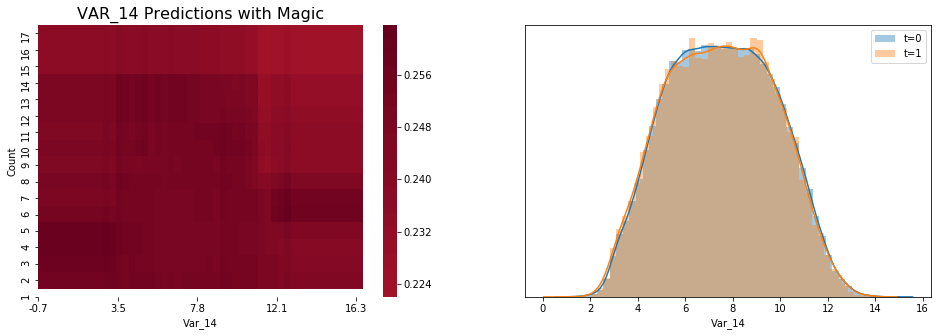

VAR_14 without magic val_auc = 0.50297


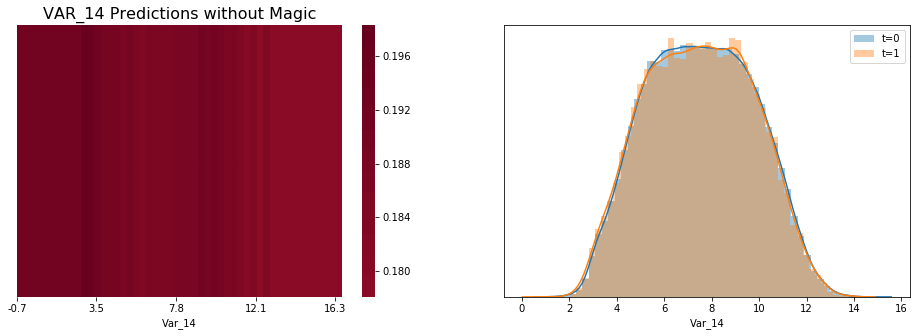

VAR_15 with magic val_auc = 0.50494


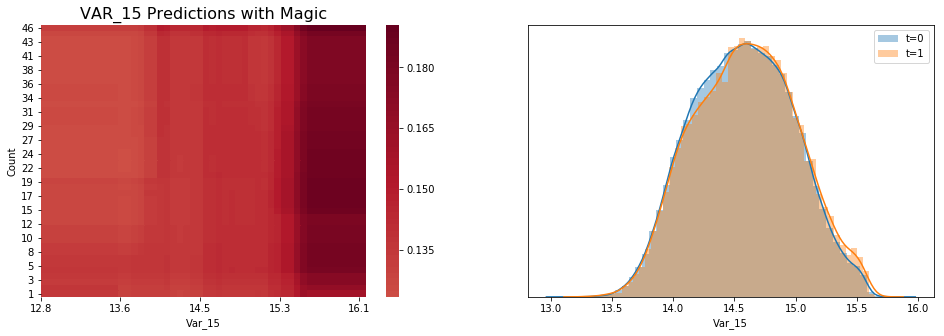

VAR_15 without magic val_auc = 0.5057


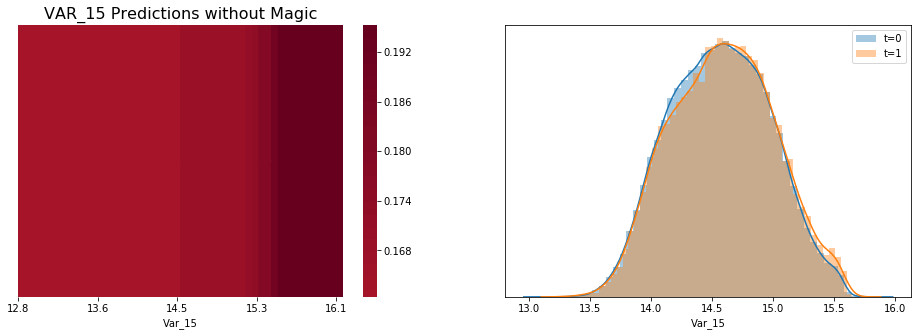

VAR_16 with magic val_auc = 0.50415


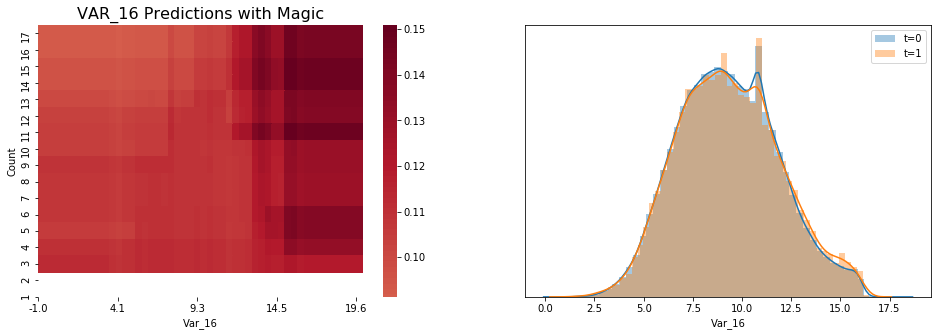

VAR_16 without magic val_auc = 0.50459


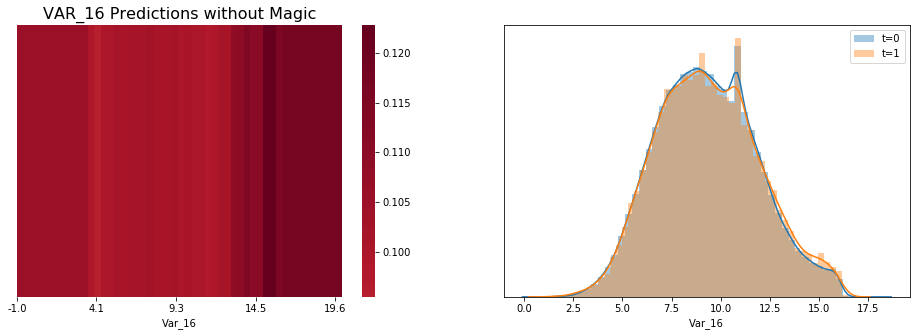

VAR_17 with magic val_auc = 0.49817


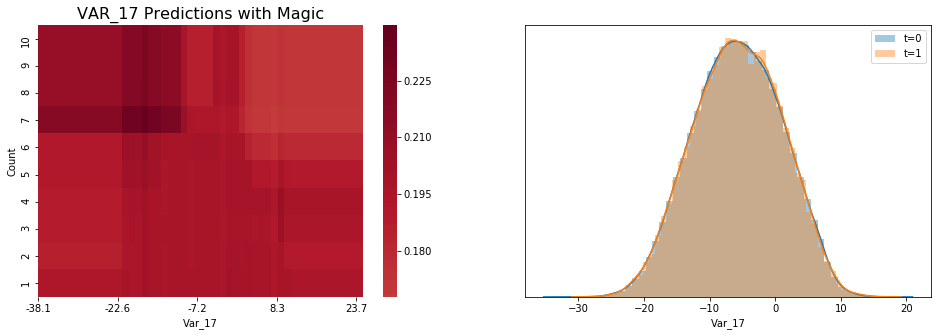

VAR_17 without magic val_auc = 0.49669


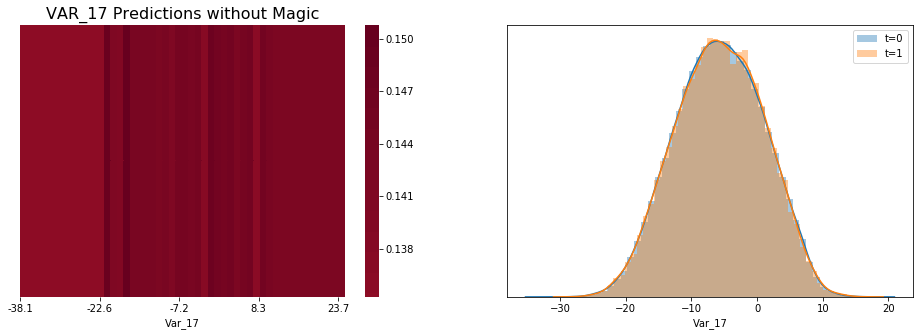

VAR_18 with magic val_auc = 0.53942


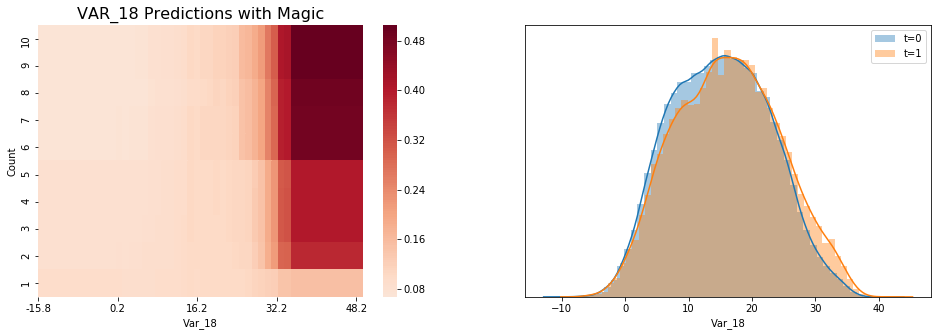

VAR_18 without magic val_auc = 0.5366


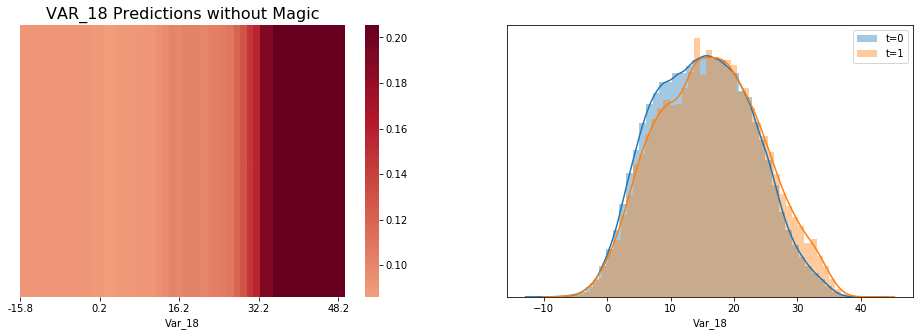

VAR_19 with magic val_auc = 0.50348


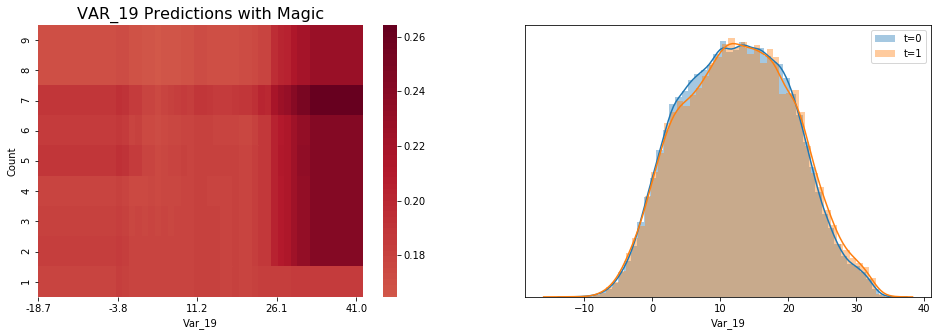

VAR_19 without magic val_auc = 0.50421


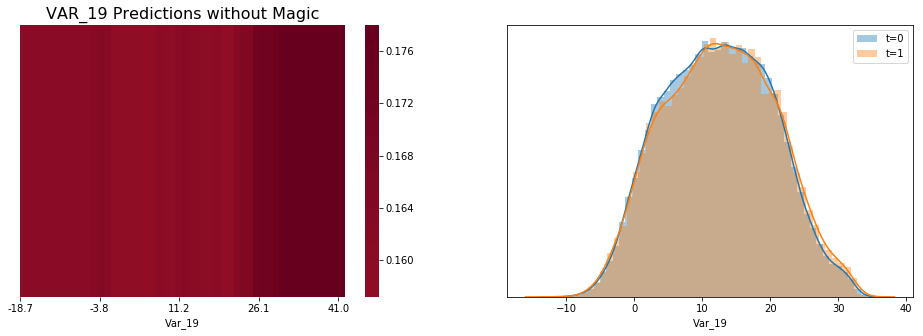

VAR_20 with magic val_auc = 0.51994


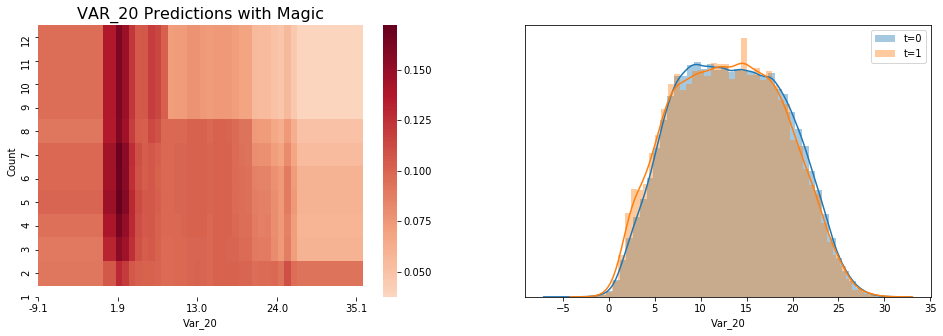

VAR_20 without magic val_auc = 0.5073


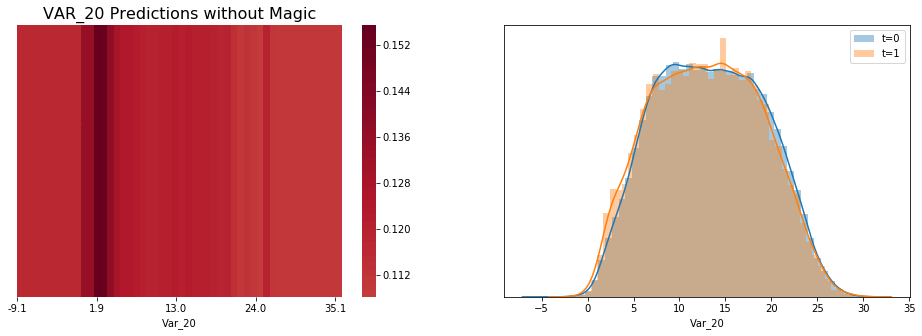

VAR_21 with magic val_auc = 0.55652


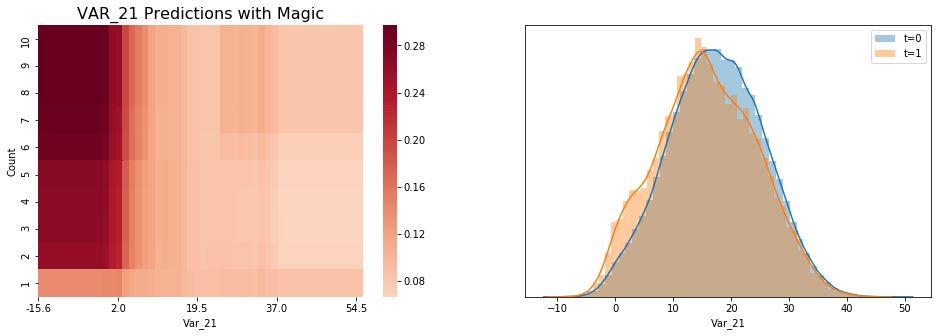

VAR_21 without magic val_auc = 0.54427


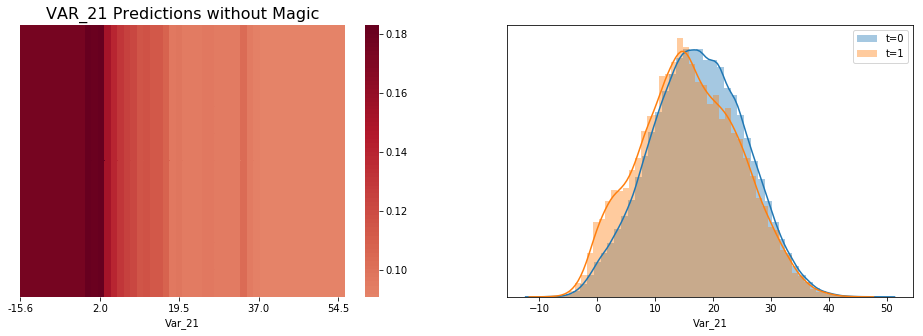

VAR_22 with magic val_auc = 0.54623


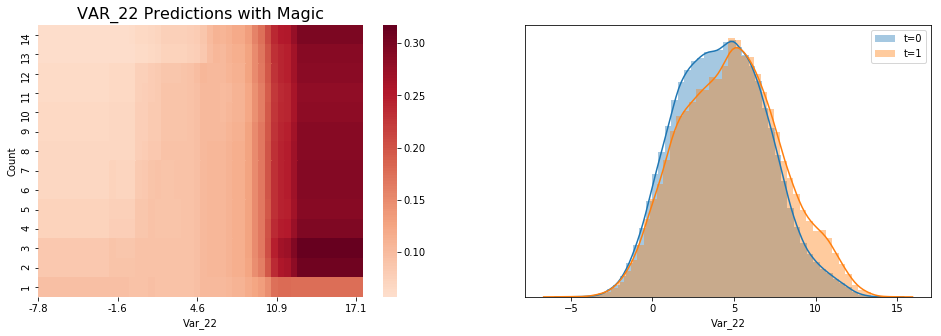

VAR_22 without magic val_auc = 0.5389


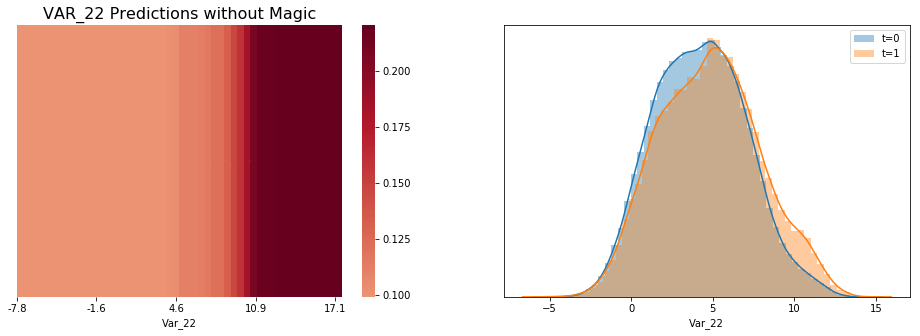

VAR_23 with magic val_auc = 0.52001


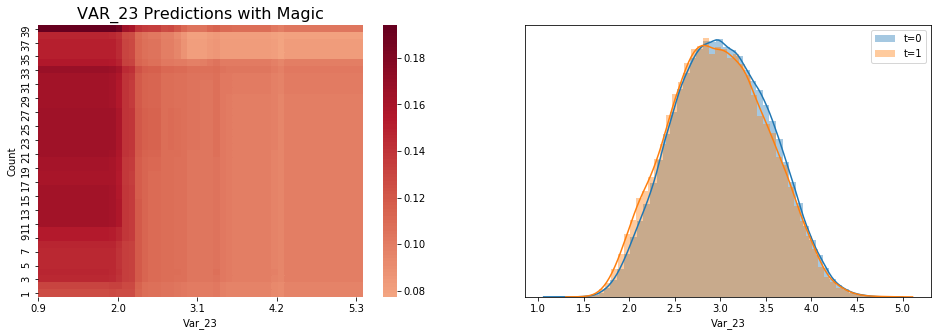

VAR_23 without magic val_auc = 0.51165


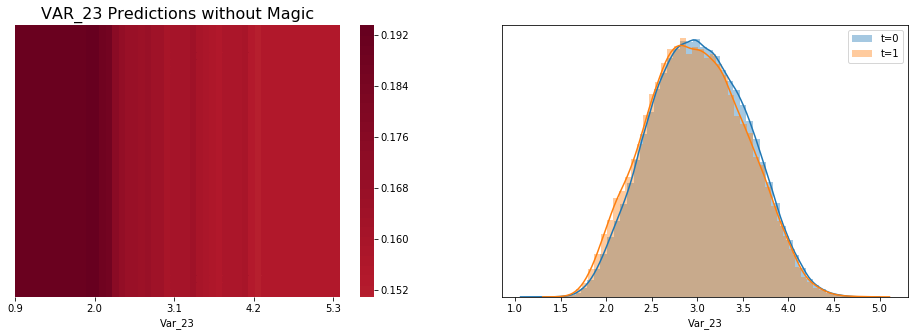

VAR_24 with magic val_auc = 0.52585


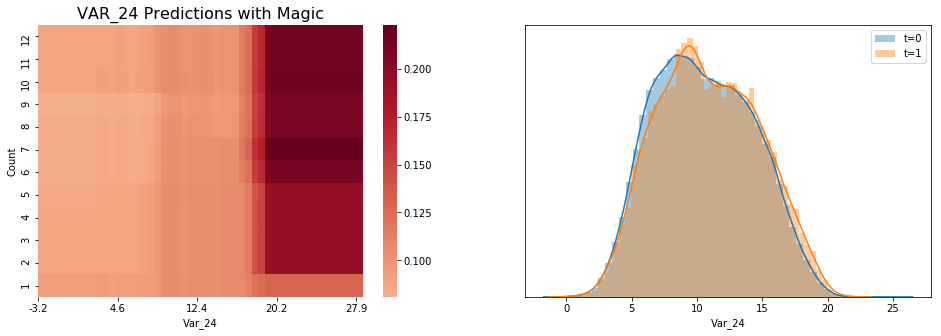

VAR_24 without magic val_auc = 0.52578


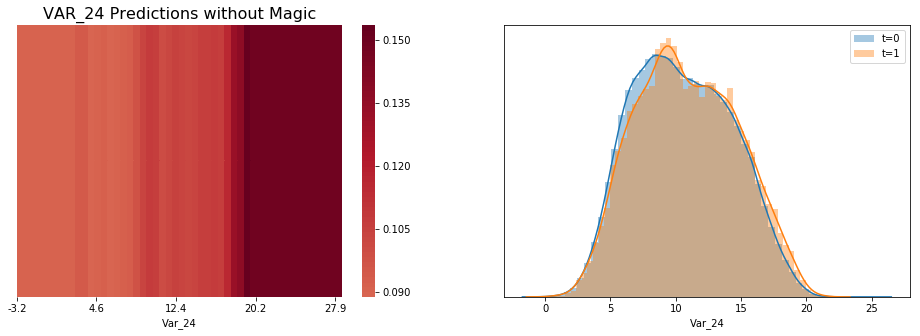

VAR_25 with magic val_auc = 0.50612


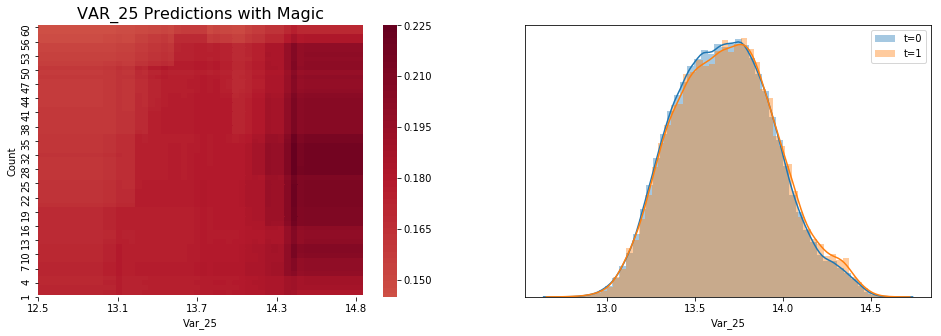

VAR_25 without magic val_auc = 0.5072


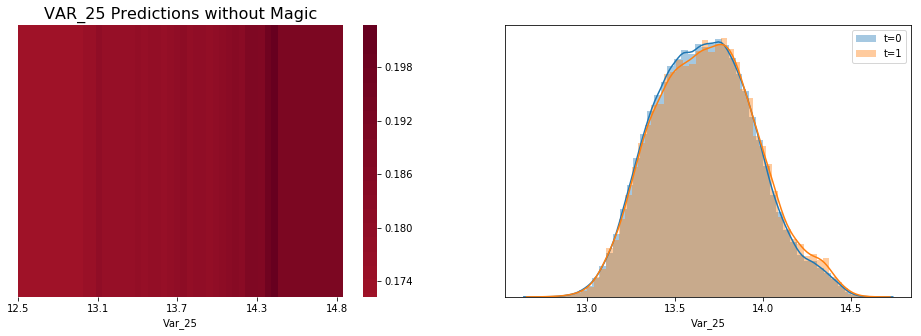

VAR_26 with magic val_auc = 0.55694


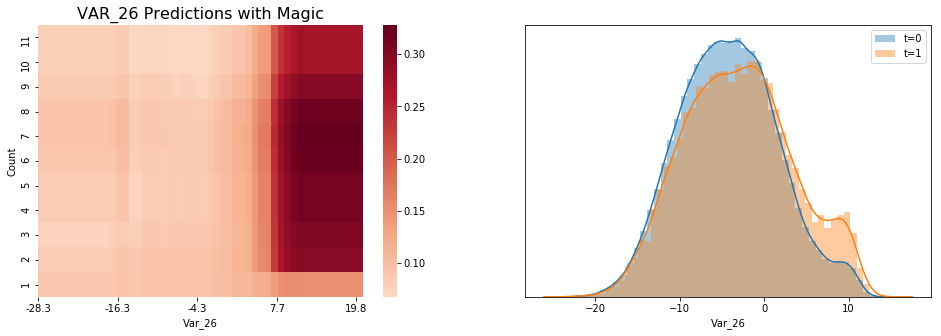

VAR_26 without magic val_auc = 0.54483


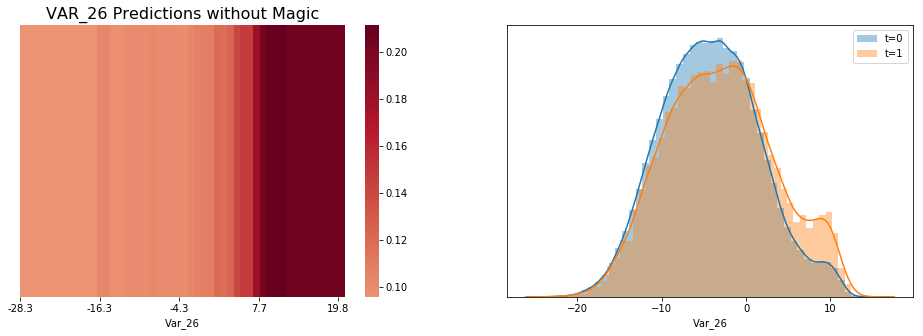

VAR_27 with magic val_auc = 0.50101


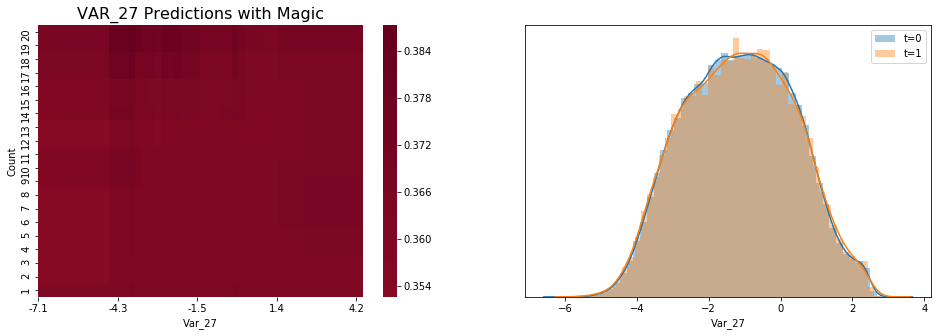

VAR_27 without magic val_auc = 0.49702


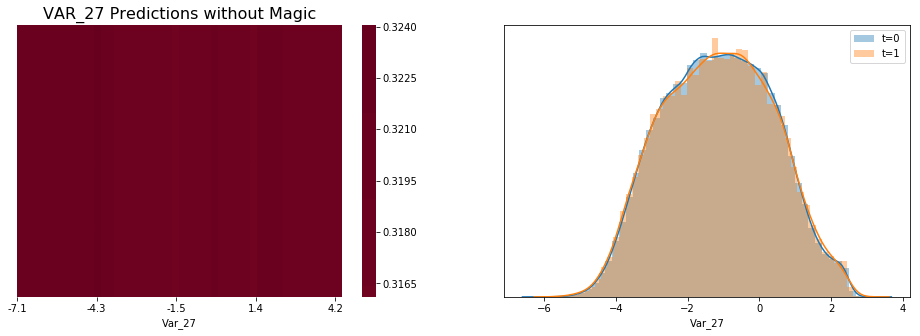

VAR_28 with magic val_auc = 0.51558


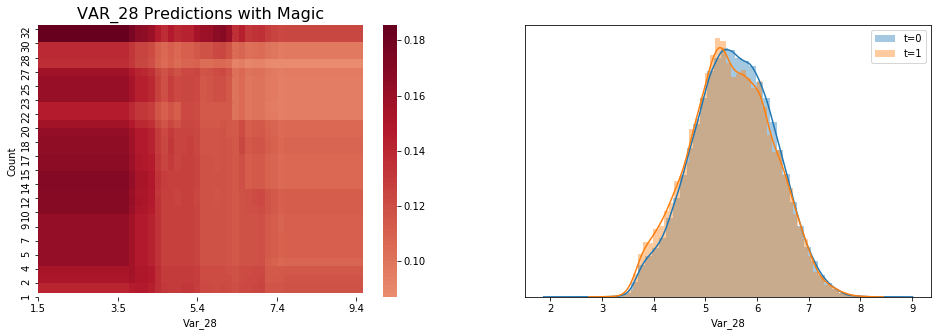

VAR_28 without magic val_auc = 0.51786


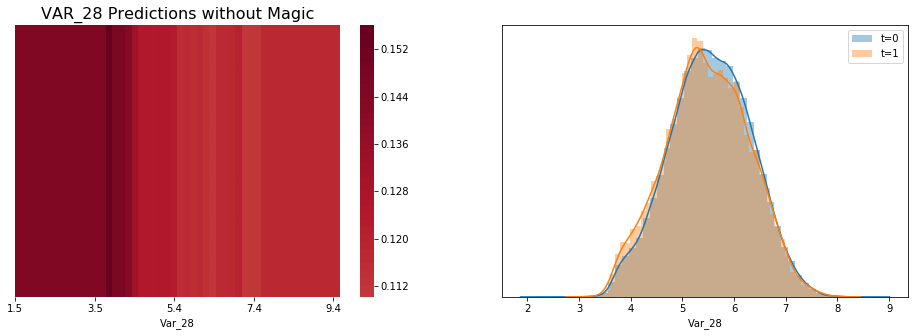

VAR_29 with magic val_auc = 0.49775


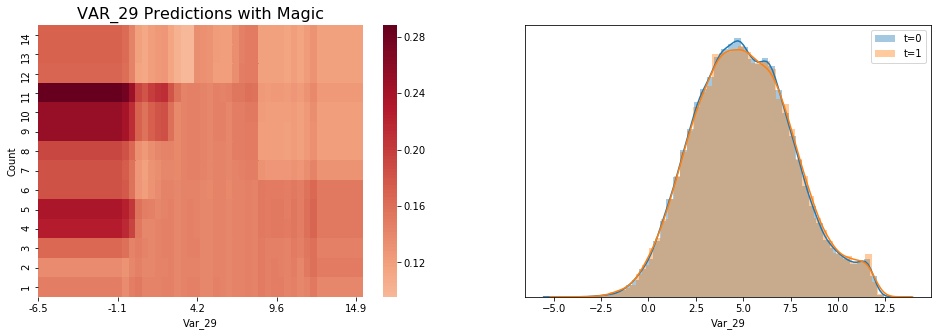

VAR_29 without magic val_auc = 0.50016


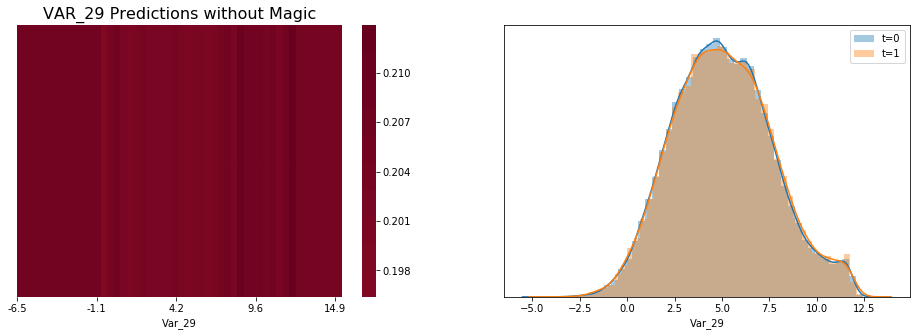

VAR_30 with magic val_auc = 0.50075


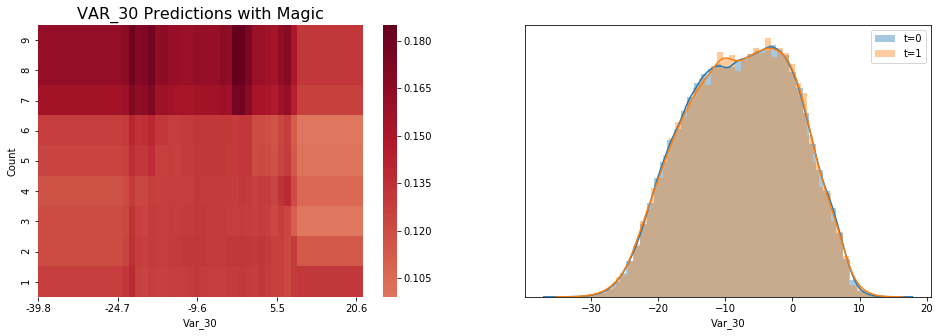

VAR_30 without magic val_auc = 0.50081


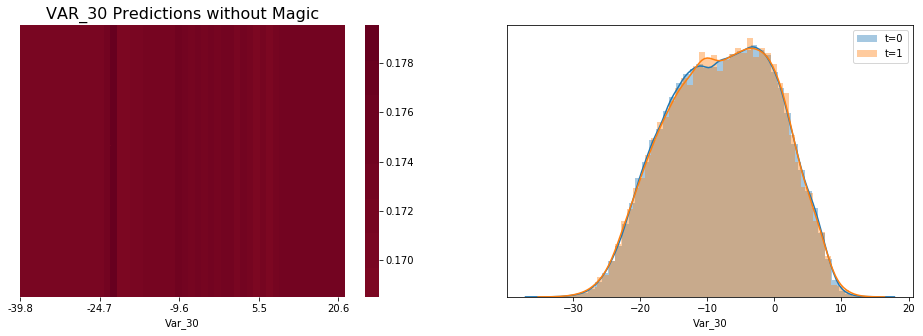

In [ ]:
# LGBM PARAMETERS
param = {
    'learning_rate': 0.04,
    'num_leaves': 3,
    'metric':'auc',
    'boost_from_average':'false',
    'feature_fraction': 1.0,
    'max_depth': -1,
    'objective': 'binary',
    'verbosity': -10}
train2 = train.sample(frac=1,random_state=42)
evals_result = {}
num_vars = 200

# SAVE OUT-OF-FOLD PREDICTIONS
all_oof = np.zeros((len(train2),num_vars+1))
all_oof[:,0] = np.ones(len(train2))
all_oofB = np.zeros((len(train2),num_vars+1))
all_oofB[:,0] = np.ones(len(train2))

# SAVE TEST PREDICTIONS
all_preds = np.zeros((len(test),num_vars+1))
all_preds[:,0] = np.ones(len(test))
all_predsB = np.zeros((len(test),num_vars+1))
all_predsB[:,0] = np.ones(len(test))

for j in range(num_vars):
    
    # MODEL WITH MAGIC
    features = ['var_'+str(j),'var_'+str(j)+'_FE']
    oof = np.zeros(len(train2))
    preds = np.zeros(len(test))
    
    # PLOT DENSITIES    
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,2)
    sns.distplot(train2[train2['target']==0]['var_'+str(j)], label = 't=0')
    sns.distplot(train2[train2['target']==1]['var_'+str(j)], label = 't=1')
    plt.legend()
    plt.yticks([])
    plt.xlabel('Var_'+str(j))

    # MAKE A GRID OF POINTS FOR LGBM TO PREDICT    
    mn,mx = plt.xlim()
    mnFE = train2['var_'+str(j)+'_FE'].min()
    mxFE = train2['var_'+str(j)+'_FE'].max()
    step = 50
    stepB = train2['var_'+str(j)+'_FE'].nunique()
    w = (mx-mn)/step
    x = w * (np.arange(0,step)+0.5) + mn
    x2 = np.array([])
    for i in range(stepB):
        x2 = np.concatenate([x,x2])
    df = pd.DataFrame({'var_'+str(j):x2})
    df['var_'+str(j)+'_FE'] = mnFE + (mxFE-mnFE)/(stepB-1) * (df.index//step)
    df['pred'] = 0
    
    # 5-FOLD WITH MAGIC
    for k in range(5):
        valid = train2.iloc[k*40000:(k+1)*40000]
        train = train2[ ~train2.index.isin(valid.index) ]    
        trn_data  = lgb.Dataset(train[features], label=train['target'])
        val_data = lgb.Dataset(valid[features], label=valid['target'])     
        model = lgb.train(param, trn_data, 750, valid_sets = [trn_data, val_data], 
                verbose_eval=False, evals_result=evals_result)      
        x = evals_result['valid_1']['auc']
        best = x.index(max(x))
        #print('i=',i,'k=',k,'best=',best)
        oof[k*40000:(k+1)*40000] = model.predict(valid[features], num_iteration=best)
        preds += model.predict(test[features], num_iteration=best)/5.0
        df['pred'] += model.predict(df[features], num_iteration=best)/5.0
            
    val_auc = roc_auc_score(train2['target'],oof)
    print('VAR_'+str(j)+' with magic val_auc =',round(val_auc,5))
    all_oof[:,j+1] = oof
    all_preds[:,j+1] = preds
    x = df['pred'].values
    x = np.reshape(x,(stepB,step))
    x = np.flip(x,axis=0)
    
    # PLOT LGBM PREDICTIONS USING MAGIC    
    plt.subplot(1,2,1)
    sns.heatmap(x, cmap='RdBu_r', center=0.0) 
    plt.title('VAR_'+str(j)+' Predictions with Magic',fontsize=16)    
    plt.xticks(np.linspace(0,49,5),np.round(np.linspace(mn,mx,5),1))
    plt.xlabel('Var_'+str(j))
    s = min(mxFE-mnFE+1,20)
    plt.yticks(np.linspace(mnFE,mxFE,s)-0.5,np.linspace(mxFE,mnFE,s).astype('int'))
    plt.ylabel('Count')
    plt.show()
    
    # MODEL WITHOUT MAGIC
    features = ['var_'+str(j)]
    oof = np.zeros(len(train2))
    preds = np.zeros(len(test))
    
    # PLOT DENSITIES
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,2)
    sns.distplot(train2[train2['target']==0]['var_'+str(j)], label = 't=0')
    sns.distplot(train2[train2['target']==1]['var_'+str(j)], label = 't=1')
    plt.legend()
    plt.yticks([])
    plt.xlabel('Var_'+str(j))
    
    # MAKE A GRID OF POINTS FOR LGBM TO PREDICT
    mn,mx = plt.xlim()
    mnFE = train2['var_'+str(j)+'_FE'].min()
    mxFE = train2['var_'+str(j)+'_FE'].max()
    step = 50
    stepB = train2['var_'+str(j)+'_FE'].nunique()
    w = (mx-mn)/step
    x = w * (np.arange(0,step)+0.5) + mn
    x2 = np.array([])
    for i in range(stepB):
        x2 = np.concatenate([x,x2])
    df = pd.DataFrame({'var_'+str(j):x2})
    df['var_'+str(j)+'_FE'] = mnFE + (mxFE-mnFE)/(stepB-1) * (df.index//step)
    df['pred'] = 0
    
    # 5-FOLD WITHOUT MAGIC
    for k in range(5):
        valid = train2.iloc[k*40000:(k+1)*40000]
        train = train2[ ~train2.index.isin(valid.index) ]
        trn_data  = lgb.Dataset(train[features], label=train['target'])
        val_data = lgb.Dataset(valid[features], label=valid['target'])     
        model = lgb.train(param, trn_data, 750, valid_sets = [trn_data, val_data], 
                verbose_eval=False, evals_result=evals_result)      
        x = evals_result['valid_1']['auc']
        best = x.index(max(x))
        #print('i=',i,'k=',k,'best=',best)
        oof[k*40000:(k+1)*40000] = model.predict(valid[features], num_iteration=best)
        preds += model.predict(test[features], num_iteration=best)/5.0
        df['pred'] += model.predict(df[features], num_iteration=best)/5.0
            
    val_auc = roc_auc_score(train2['target'],oof)
    print('VAR_'+str(j)+' without magic val_auc =',round(val_auc,5))
    all_oofB[:,j+1] = oof
    all_predsB[:,j+1] = preds
    x = df['pred'].values
    x = np.reshape(x,(stepB,step))
    x = np.flip(x,axis=0)
    
    # PLOT LGBM PREDICTIONS WITHOUT USING MAGIC
    plt.subplot(1,2,1)
    sns.heatmap(x, cmap='RdBu_r', center=0.0) 
    plt.title('VAR_'+str(j)+' Predictions without Magic',fontsize=16)
    plt.xticks(np.linspace(0,49,5),np.round(np.linspace(mn,mx,5),1))
    plt.xlabel('Var_'+str(j))
    plt.yticks([])
    plt.ylabel('')
    plt.show()

# Ensemble 200 Models with LR
We now have a model for each variable and its predictions on test and its out-of-fold predictions on train. 

If we just add (or multiply) the predictions together, the AUC is low. 

Instead we will use logistic regression to ensemble them. 

Each set of predictions is a vector of length 200000. We have 200 vectors of out-of-fold predictions, call them `x1, x2, x3, ..., x200`. 

We know the true train target, call it `y`. We will now use logistic regression to find 200 coefficients (model y from x's). Then we will use those coefficients to combine our 200 test predictions to create a submission.

In [ ]:
# ENSEMBLE MODEL WITHOUT MAGIC
logrB = sm.Logit(train2['target'], all_oofB[:,:num_vars+1])
logrB = logrB.fit(disp=0)
ensemble_predsB = logrB.predict(all_oofB[:,:num_vars+1])
ensemble_aucB = roc_auc_score(train2['target'],ensemble_predsB)  
print('##################')
print('Combined Model without magic Val_AUC=',round(ensemble_aucB,5))
print()

# ENSEMBLE MODEL WITH MAGIC
logr = sm.Logit(train2['target'], all_oof[:,:num_vars+1])
logr = logr.fit(disp=0)
ensemble_preds = logr.predict(all_oof[:,:num_vars+1])
ensemble_auc = roc_auc_score(train2['target'],ensemble_preds)  
print('##################')
print('Combined Model with magic Val_AUC=',round(ensemble_auc,5))
print()

##################
Combined Model without magic Val_AUC= 0.89698

##################
Combined Model with magic Val_AUC= 0.92011

In [ ]:
# SAVE PREDICTIONS TO CSV    
print('Test predictions saved as submission.csv')
print('OOF predictions saved as oof_submission.csv')
print('Histogram of test predictions displayed below:')

sub = train2[['ID_code','target']].copy()
sub['predict'] = ensemble_preds
sub.reset_index(inplace=True)
sub.sort_values('index',inplace=True)
sub.to_csv('oof_submission.csv',index=False)

test_preds = logr.predict(all_preds[:,:num_vars+1])
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = test_preds
sub.to_csv('submission.csv',index=False)

# DISPLAY HISTOGRAM OF PREDICTIONS
b = plt.hist(sub['target'], bins=200)